In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, ParameterGrid, RandomizedSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

seed = 72

In [22]:
data   = pd.read_csv("data.csv")
data = data.dropna(axis=1, how='all')

##Se separan los datos para testeo y validacion

In [23]:
X = data.drop(columns=data.columns[1])
y = data.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=seed
)

##Se selecciona el mejor modelo que mejor generaliza el problema


In [4]:
#-------------------------------------------------------------------------------------

arbol = DecisionTreeClassifier(random_state=seed)
param_dist = {
    'max_depth': [3, 4, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10, 15],
    'criterion': ['gini', 'entropy'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05]
}
search = RandomizedSearchCV(
    estimator=arbol,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=seed,
)
search.fit(X_train, y_train.values.ravel())
print()
print("Mejores hiperparámetros para arbol de decision:")
print(search.best_params_)
print()
print("Mejor score:")
print(search.best_score_)

#-------------------------------------------------------------------------------------


Mejores hiperparámetros para arbol de decision:
{'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 20, 'criterion': 'entropy', 'ccp_alpha': 0.01}

Mejor score:
0.9738390092879257


In [5]:
#-------------------------------------------------------------------------------------

pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=seed))
])

param_dist_svm = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

search_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_dist_svm,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=seed
)

search_svm.fit(X_train, y_train.values.ravel())

print("Mejores hiperparámetros para SVM:")
print(search_svm.best_params_)
print("Mejor score para SVM:")
print(search_svm.best_score_)

#-------------------------------------------------------------------------------------

Mejores hiperparámetros para SVM:
{'svm__kernel': 'linear', 'svm__gamma': 'scale', 'svm__C': 1}
Mejor score para SVM:
0.9933952528379774


In [6]:
#-------------------------------------------------------------------------------------

pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_dist_knn = {
    'knn__n_neighbors': list(range(1, 31)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

search_knn = RandomizedSearchCV(
    estimator=pipeline_knn,
    param_distributions=param_dist_knn,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=seed
)

search_knn.fit(X_train, y_train.values.ravel())

print()
print("Mejores hiperparámetros para KNN:")
print(search_knn.best_params_)
print()
print("Mejor score para KNN:")
print(search_knn.best_score_)

#-------------------------------------------------------------------------------------


Mejores hiperparámetros para KNN:
{'knn__weights': 'distance', 'knn__n_neighbors': 12, 'knn__metric': 'euclidean'}

Mejor score para KNN:
0.9915376676986585


In [7]:
#-------------------------------------------------------------------------------------

lda = LinearDiscriminantAnalysis()
y_train_1d = y_train.squeeze()
lda.fit(X_train, y_train_1d)
y_proba_lda = lda.predict_proba(X_test)[:, 1]
auc_lda = roc_auc_score(y_test, y_proba_lda)
print("performance para LDA:", auc_lda)

#-------------------------------------------------------------------------------------

nb = GaussianNB()
nb.fit(X_train, y_train_1d)
y_proba_nb = nb.predict_proba(X_test)[:, 1]
auc_nb = roc_auc_score(y_test, y_proba_nb)
print("performance para Naive Bayes:", auc_nb)

#-------------------------------------------------------------------------------------

performance para LDA: 0.9811507936507937
performance para Naive Bayes: 0.8134920634920635


In [8]:
#-------------------------------------------------------------------------------------

pipeline_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=seed))
])

param_dist_rf = {
    'rf__n_estimators': [50, 100, 200, 300],
    'rf__max_depth': [None, 5, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False],
    'rf__max_features': ['sqrt', 'log2', None]
}

search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    scoring='roc_auc',
    cv=5,
    random_state=seed,
    n_jobs=-1
)

search_rf.fit(X_train, y_train.values.ravel())

print()
print("Mejores hiperparámetros para Random Forest:")
print(search_rf.best_params_)
print()
print("Mejor score para Random Forest:")
print(search_rf.best_score_)

#-------------------------------------------------------------------------------------


Mejores hiperparámetros para Random Forest:
{'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': 10, 'rf__bootstrap': True}

Mejor score para Random Forest:
0.9921568627450981


##Validacion del modelo

In [10]:
best_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1, probability=True, gamma='scale',kernel='linear', random_state=seed))
])

In [27]:
y_train_bin = y_train.replace({'M': 1, 'B': 0}).astype(int)
y_test_bin = y_test.replace({'M': 1, 'B': 0}).astype(int)

best_svm.fit(X_train, y_train_bin.values.ravel())
y_pred_svm = best_svm.predict(X_test)

y_pred_bin = pd.Series(y_pred_svm).replace({'M': 1, 'B': 0})

auc_svm = np.round(roc_auc_score(y_test_bin, y_pred_bin), 4)
recall_svm = np.round(recall_score(y_test_bin, y_pred_bin), 4)

print("AUCROC:", auc_svm)
print("Recall:", recall_svm)

AUCROC: 0.9385
Recall: 0.9048


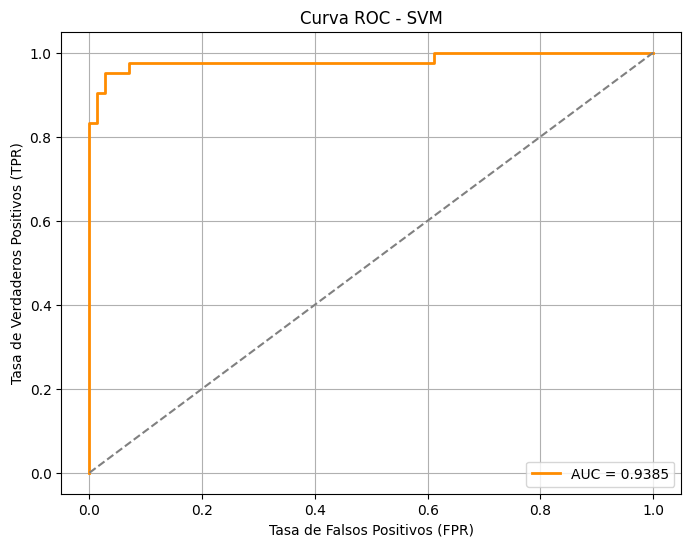

In [30]:
y_scores = best_svm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test_bin, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_svm}', color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

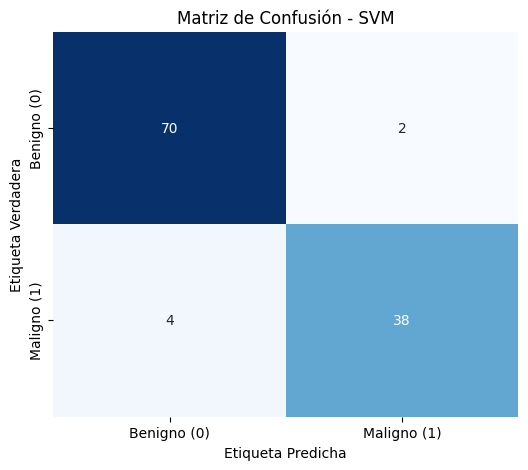

In [31]:
cm = confusion_matrix(y_test_bin, y_pred_svm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Benigno (0)', 'Maligno (1)'],
            yticklabels=['Benigno (0)', 'Maligno (1)'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - SVM')
plt.show()